In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import torch
import torchvision
import os
from skimage.io import imread
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import skimage
import torch.nn as nn
import torch.nn.functional as F


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [52]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):

        self.output_size = output_size

    def __call__(self, sample):
        image = sample # of shape HxWx3
        output_size=self.output_size
        h, w = image.shape[:2]
        
        end_h=h-output_size
        end_w=w-output_size
    
        h_s=np.random.randint(0,end_h)
        w_s=np.random.randint(0,end_w)
    
        h_e=h_s+output_size
        w_e=w_s+output_size
        image=image[h_s:h_e,w_s:w_e,:]
 

        return image

class ToYcbcr(object):
    """Convert rgb image to Ycbcr image and keep the Y channel to feed to the SRNW. CbCr channels are stored separately.
    Output will be tensor of shape 1xHxW"""
    def __call__(self,sample):
        # if is grayscale=>no transform needed
        if sample.shape[-1]==1:
            return sample
        else:

            image=skimage.color.rgb2ycbcr(sample,channel_axis=-1) # of shape HxWx3

            image=torch.tensor(image,dtype=torch.float32)

            #reshape image to 3xHxW
            image=image.permute(2,0,1) 
            #only keep the y_channel
            image=torch.unsqueeze(image[0],dim=0)
            # scale input image to range [0,1]
            image=(image-16.0)/235.0

            return image


class ToBlur(object):
    def __init__(self,kernel_size):
        self.kernel_size=kernel_size
    def __call__(self,sample):
        
        
        image=torchvision.transforms.functional.gaussian_blur(sample,kernel_size=self.kernel_size,sigma=(0.1,1.5))
        
        image=torch.clamp(image,min=0,max=1)
        return {'image': image,
                'landmarks': sample}

class SubUp(object):
    def __init__(self,factor):
        self.factor=factor
    def __call__(self,sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        factor=self.factor
        image=image[:,::factor,::factor]
        
        #comment out three lines below to use original low_quality image without upsampling
        # upsample=torchvision.transforms.Resize(size, interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
        # image=upsample.forward(image)
        # image=torch.clamp(image,min=-1,max=1)
                
        return {'image': image,
                'landmarks':landmarks}                                                              
    

In [65]:
class Dataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dirs,repeat, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        paths=list()
        for root_dir in root_dirs:
            list_path=[os.path.join(root_dir,fname) for fname in os.listdir(root_dir)]
            paths=paths+list_path
        
        self.paths = paths*repeat
        self.root_dirs = root_dirs
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.paths[idx]
        sample = plt.imread(img_name)
        if sample.shape[-1]>3:
            sample=sample[:,:,0:3]
        # of shape HxWx3
                
        if self.transform:
            sample = self.transform(sample)

        return sample
        

In [66]:
if torch.cuda.is_available():
    print('Good!')
    DEVICE=torch.device('cuda')
else:
    DEVICE=torch.device('cpu')

Good!


In [67]:
transformer=transforms.Compose([RandomCrop(54),
                                ToYcbcr(),
                                ToBlur(kernel_size=3),
                                SubUp(factor=2)
                               ])

In [68]:

class SuperReso(nn.Module):
    def __init__(self):
        super(SuperReso,self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 5,padding='same')
        # nn.init.normal_(self.conv1.weight,mean=0,std=0.001)
        self.batchnorm1=nn.BatchNorm2d(64)
        self.prelu1=nn.PReLU(init=0.2)
        
        self.conv2 = nn.Conv2d(64,32 ,3,padding='same')
        # nn.init.normal_(self.conv1.weight,mean=0,std=0.001)
        self.batchnorm2=nn.BatchNorm2d(32)
        self.prelu2=nn.PReLU(init=0.2)
        
        self.conv3=nn.Conv2d(32,4,3,padding='same')
        # nn.init.normal_(self.conv1.weight,mean=0,std=0.001)
        
        self.subpixel=nn.PixelShuffle(2)

    def forward(self, x):
        x=self.conv1(x)
        x=self.batchnorm1(x)
        x=self.prelu1(x)
        x=self.conv2(x)
        x=self.batchnorm2(x)
        x=self.prelu2(x)
        x=self.conv3(x)
        x=self.subpixel(x)
        
        return x
        

In [69]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [82]:
model=SuperReso()
# model.apply(weights_init)
model.load_state_dict(torch.load('/kaggle/working/model_303.pt'))
model.to(DEVICE)

SuperReso(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu1): PReLU(num_parameters=1)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu2): PReLU(num_parameters=1)
  (conv3): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (subpixel): PixelShuffle(upscale_factor=2)
)

In [83]:
train_dir=['/kaggle/input/superresolution/nature','/kaggle/input/superresolution/busystreet',
           '/kaggle/input/superresolution/wildlife']
           
valid_dir=['/kaggle/input/sr1-data/SR1/SR_testing_datasets/BSDS100']


In [84]:
(2507+1999+345)*3/128

113.6953125

In [85]:
transformed_dataset = Dataset( root_dirs=train_dir,repeat=3,
                                transform=transformer)
transformed_validset = Dataset( root_dirs=valid_dir,repeat=1,
                                transform=transformer)

In [86]:
training_loader = DataLoader(transformed_dataset, batch_size=128,
                        shuffle=True, num_workers=0,drop_last=True)
validation_loader = DataLoader(transformed_validset, batch_size=32,
                        shuffle=True, num_workers=0,drop_last=True)

In [74]:
data_iter=iter(training_loader)
data_iter_item=next(data_iter)
data_iter_item['image'].size()

torch.Size([128, 1, 27, 27])

In [87]:
def train_one_epoch(num_batch):
    running_loss = 0.
    last_loss=0.

    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs= data['image'].to(DEVICE)

        labels=data['landmarks'].to(DEVICE)
        
        optimizer.zero_grad()
        preds=model(inputs)

        loss=loss_fn(preds,labels)
        # update gradients
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        
        if i % num_batch == (num_batch-1):
            last_loss = running_loss / num_batch # loss per batc
     
            running_loss = 0.

    return last_loss

In [88]:
loss_fn=torch.nn.MSELoss()
optimizer = torch.optim.Adam(
    [
        {"params": model.conv1.parameters(), "lr": 1e-4},
        {"params": model.conv2.parameters(),"lr":1e-4},
        # {"params": model.conv4.parameters(),"lr":1e-4},
        # {"params": model.conv5.parameters(),"lr":1e-4},
        # {"params": model.conv6.parameters(),"lr":1e-4},
        {"params": model.conv3.parameters(),"lr":1e-5},
    ],
    lr=5e-5,
)

In [89]:
his=dict()

In [ ]:

epoch_number = 305
num_batch=113
EPOCHS = 20

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(num_batch)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs=vdata['image'].to(DEVICE)
            vlabels=vdata['landmarks'].to(DEVICE)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print(" train loss is {} , valid loss is {} \n".format(avg_loss,avg_vloss))

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '/kaggle/working/model_{}.pt'.format(epoch_number+1)
        torch.save(model.state_dict(), model_path)
    with open('his.txt','a') as fhand:
        fhand.writelines("EPOCH {} : train loss is {} , valid loss is {} \n".format(epoch_number+1,avg_loss,avg_vloss))
        fhand.close()
    epoch_number += 1

EPOCH 306:
 train loss is 0.004233269651412173 , valid loss is 0.005960231646895409 

EPOCH 307:
 train loss is 0.0033882238234566376 , valid loss is 0.004070881754159927 

EPOCH 308:


In [21]:
model_path = '/kaggle/working/model_{}.pt'.format(185)
torch.save(model.state_dict(), model_path)

In [127]:
def train_disc(epoch_index,num_batch):
    running_disc_loss = 0.
    last_disc_loss=0.
#     last_gen_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs= data['image'].to(DEVICE)

        labels=data['landmarks'].to(DEVICE)

        # Update discriminator
        disc_opt.zero_grad()
        # create fake hr image
        fake_img=gen(inputs)
        disc_fake_pred=disc(fake_img.detach())
        disc_fake_loss=loss_gan(disc_fake_pred,torch.zeros_like(disc_fake_pred))
        disc_real_pred=disc(labels)

        disc_real_loss=loss_gan(disc_real_pred,torch.ones_like(disc_real_pred))
        
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()
        # Gather data and report
        running_disc_loss += disc_loss.item()
        

        if i % num_batch == (num_batch-1):
            last_disc_loss = running_disc_loss / num_batch # loss per batch
            print(' batch {} disc loss: {}'.format(i + 1, last_disc_loss))
     
            running_disc_loss = 0.

    return last_disc_loss

In [129]:
disc=Disc()
# disc=disc.apply(weights_init)
disc.load_state_dict(torch.load('/kaggle/working/disc_init.pt'))
disc.to(DEVICE)

Disc(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (block1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (block2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (block3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (

In [130]:
# F.sigmoid(disc(data_iter_item['landmarks'].to(DEVICE)))

In [131]:
gen=SuperReso()
gen.to(DEVICE)
gen.load_state_dict(torch.load('/kaggle/input/normal-55/model_batch_norm55'))

<All keys matched successfully>

In [132]:
lr = 2e-5
# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
gen_opt = torch.optim.Adam( [
                                {"params": gen.conv1.parameters(), "lr": 1e-4},
                                {"params": gen.conv2.parameters(),"lr":1e-4},
            
                                {"params": gen.conv3.parameters(),"lr":1e-5},
                            ]
                           , lr=1e-5, betas=(beta_1, beta_2))

disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

In [28]:
torch.save(disc.state_dict(),'/kaggle/working/disc_init.pt')

In [112]:
# train gen 2 epochs then train 1 epoch of gen and disc together
epoch_number=0
EPOCHS=3*5
num_batch=88
alpha=5
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    if epoch%3==2:
    

    # Make sure gradient tracking is on, and do a pass over the data
        gen.train(True)
        disc.train(True)
        last_disc_loss,last_gen_loss=train_one_epoch(epoch_number,num_batch,alpha)
    else:
        gen.train(True)
        disc.train(False)
        last_gen_loss=train_gen(epoch_number,num_batch,alpha)
        last_disc_loss=0
    if epoch in (7,8,13,14) :
        gen_model_path='gen_f_{}.pt'.format(epoch_number+1)
        disc_model_path='disc_f_{}.pt'.format(epoch_number+1)
        torch.save(gen.state_dict(),gen_model_path)
        torch.save(disc.state_dict(),disc_model_path)
        print('Saved!')
    
    with open('his_2.txt','a') as fhand:
        fhand.writelines("EPOCH {} : disc loss is {} , gen loss is {} \n".format(epoch_number+1,last_disc_loss,last_gen_loss))
        fhand.close()
        
        
    epoch_number+=1


EPOCH 1:
 batch 88 gen loss: 0.22152645530348475
EPOCH 2:
 batch 88 gen loss: 0.08435332072390751
EPOCH 3:
 batch 88 disc loss: 0.5904942568052899 
 gen loss: 0.5858169919387861
EPOCH 4:
 batch 88 gen loss: 0.1464101615446535
EPOCH 5:
 batch 88 gen loss: 0.0639913418668915
EPOCH 6:
 batch 88 disc loss: 0.417681080035188 
 gen loss: 1.0267483548007228
EPOCH 7:
 batch 88 gen loss: 0.3429208575663241
EPOCH 8:
 batch 88 gen loss: 0.14346443345262247
Saved!
EPOCH 9:
 batch 88 disc loss: 0.2400236903605136 
 gen loss: 1.5664316561411729
Saved!
EPOCH 10:
 batch 88 gen loss: 0.4589714843102477
EPOCH 11:
 batch 88 gen loss: 0.19714552773670715
EPOCH 12:
 batch 88 disc loss: 0.15379730984568596 
 gen loss: 1.9131836227395318
EPOCH 13:
 batch 88 gen loss: 0.3546802001920613
EPOCH 14:
 batch 88 gen loss: 0.12494563023475083
Saved!
EPOCH 15:
 batch 88 disc loss: 0.1352540279992602 
 gen loss: 2.176602363586426
Saved!


In [39]:
model=SuperReso()
model.load_state_dict(torch.load('/kaggle/input/normal-55/model_batch_norm55'))
model.to(DEVICE)

SuperReso(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu1): PReLU(num_parameters=1)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu2): PReLU(num_parameters=1)
  (conv3): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (subpixel): PixelShuffle(upscale_factor=3)
)

In [72]:
gen.load_state_dict(torch.load('/kaggle/working/gen_f_30.pt'))
gen.to(DEVICE)

SuperReso(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu1): PReLU(num_parameters=1)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu2): PReLU(num_parameters=1)
  (conv3): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (subpixel): PixelShuffle(upscale_factor=3)
)

In [170]:
sr=gen(data_iter_item['image'].to(DEVICE))
sr_init=model(data_iter_item['image'].to(DEVICE))
hr=data_iter_item['landmarks'].to(DEVICE)

In [171]:
loss_cont(sr,hr)

tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward0>)

In [172]:
loss_cont(sr_init,hr)

tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward0>)

In [173]:
sr=sr.permute(0,2,3,1)
hr=hr.permute(0,2,3,1)
sr_init=sr_init.permute(0,2,3,1)

In [174]:
sr.shape


torch.Size([128, 54, 54, 1])

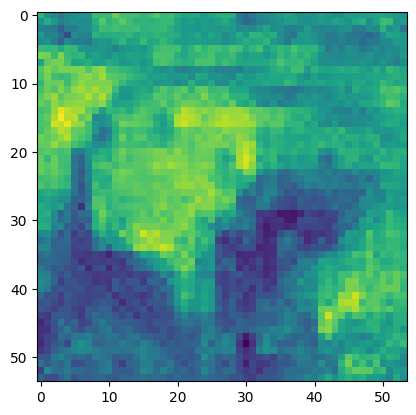

In [175]:
plt.imshow(sr[4].detach().cpu())

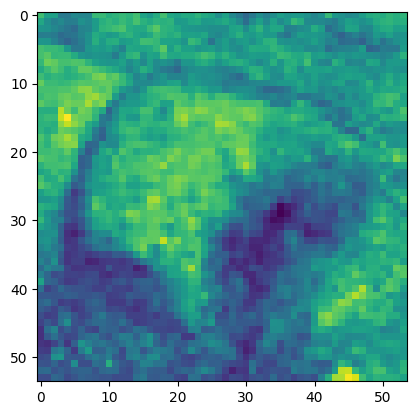

In [176]:
plt.imshow(hr[4].detach().cpu())

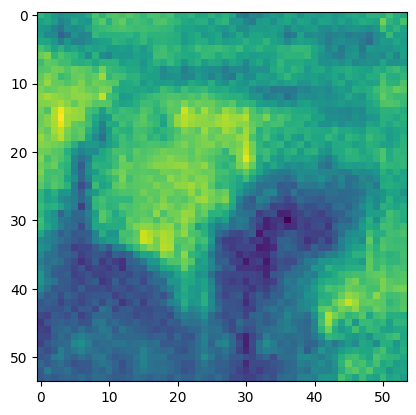

In [177]:
plt.imshow(sr_init[4].detach().cpu())

In [144]:
vgg=torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)

In [161]:
# freeze vgg model
for param in vgg.parameters():
    param.requires_grad=False
    

In [166]:
vgg.to(DEVICE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [179]:
def loss_fn(image,label):
    # repeat 3 times => Bx3xHxW
    image=torch.concatenate((image,image,image),dim=1)
    label=torch.concatenate((label,label,label),dim=1)
    img_layer1=vgg.features[:4](image)
    img_layer2=vgg.features[:9](image)
    img_layer3=vgg.features[:18](image)
    
    
    label_layer1=vgg.features[:4](label)
    label_layer2=vgg.features[:9](label)
    label_layer3=vgg.features[:18](label)
    
    loss_vgg=0.5*loss_cont(img_layer1,label_layer1)+0.05*loss_cont(img_layer2,label_layer2)+0.01*loss_cont(img_layer3,label_layer3)
    loss_content=loss_cont(image,label)
    loss=loss_vgg+loss_content
    return loss
    

In [182]:
gen=SuperReso()
gen.load_state_dict(torch.load('/kaggle/input/normal-55/model_batch_norm55'))
gen.to(DEVICE)

SuperReso(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu1): PReLU(num_parameters=1)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu2): PReLU(num_parameters=1)
  (conv3): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (subpixel): PixelShuffle(upscale_factor=3)
)

In [184]:
beta_1 = 0.5 
beta_2 = 0.999
gen_opt = torch.optim.Adam( [
                                {"params": gen.conv1.parameters(), "lr": 1e-4},
                                {"params": gen.conv2.parameters(),"lr":1e-4},
            
                                {"params": gen.conv3.parameters(),"lr":1e-5},
                            ]
                           , lr=1e-5, betas=(beta_1, beta_2))

In [187]:
loss_cont=torch.nn.MSELoss()

In [188]:
def train_new_epoch(epoch_ind,num_batch):
    running_gen_loss = 0.
    last_gen_loss=0.

    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs= data['image'].to(DEVICE)

        labels=data['landmarks'].to(DEVICE)
        
        gen_opt.zero_grad()
        fake_img=gen(inputs)

        gen_loss=loss_fn(fake_img,labels)
        # update gradients
        gen_loss.backward()
        gen_opt.step()

        running_gen_loss+=gen_loss.item()
        
        if i % num_batch == (num_batch-1):
            last_gen_loss = running_gen_loss / num_batch # loss per batch
            print(' batch {} gen loss: {}'.format(i + 1, last_gen_loss))
     
            running_gen_loss = 0.

    return last_gen_loss

In [212]:
for epoch in range(10):
    print('EPOCH {}'.format(epoch+1))
    train_new_epoch(epoch,88)

EPOCH 1
 batch 88 gen loss: 0.08321696248921481
EPOCH 2
 batch 88 gen loss: 0.08174185023050416
EPOCH 3
 batch 88 gen loss: 0.08295009708540006
EPOCH 4
 batch 88 gen loss: 0.08194788020442832
EPOCH 5
 batch 88 gen loss: 0.08336710548875007
EPOCH 6
 batch 88 gen loss: 0.0834216470406814
EPOCH 7
 batch 88 gen loss: 0.08310061854056337
EPOCH 8
 batch 88 gen loss: 0.08211568582125685
EPOCH 9
 batch 88 gen loss: 0.08217652031982486
EPOCH 10
 batch 88 gen loss: 0.08148552689023993


In [232]:
torch.save(gen.state_dict(),'/kaggle/working/model_vgg_2.pt')

In [233]:
sr=gen(data_iter_item['image'].to(DEVICE))
sr_init=model(data_iter_item['image'].to(DEVICE))
hr=data_iter_item['landmarks'].to(DEVICE)

In [234]:
sr=sr.permute(0,2,3,1)
hr=hr.permute(0,2,3,1)
sr_init=sr_init.permute(0,2,3,1)

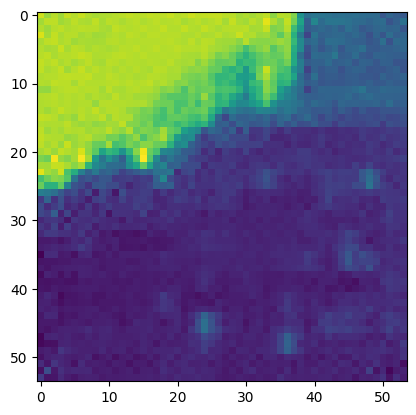

In [243]:
plt.imshow(sr[12].detach().cpu())

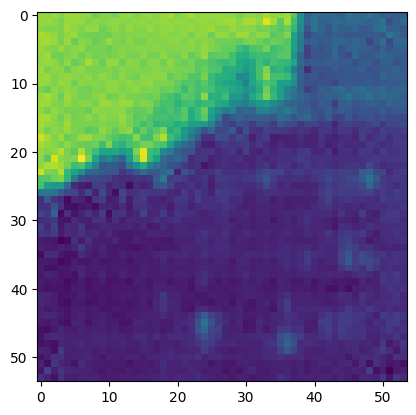

In [244]:
plt.imshow(sr_init[12].detach().cpu())

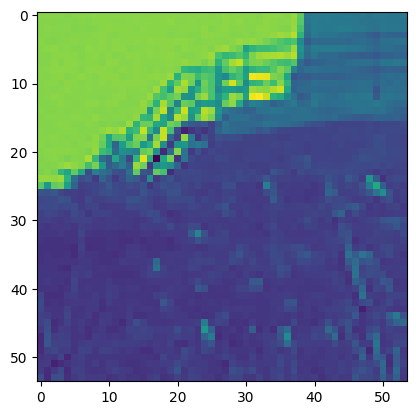

In [245]:
plt.imshow(hr[12].detach().cpu())